# Load data from URL and Check DataFrame

In [1]:
%pip install patool
import patoolib
import pandas as pd
import requests
import os

URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'
URL_2 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00281/Qualitative_Bankruptcy%20(250%20instances).rar'
FILEPATH_2 = 'Qualitative_Bankruptcy/Qualitative_Bankruptcy.data.txt'

# get first dataframe using pandas URL util
df = pd.read_excel(URL)

# get second dataframe by requests + rar extract
data = requests.get(URL_2)
with open('tmp.rar', 'wb') as f:
    f.write(data.content)

if not os.path.isdir('myarchive'):
  os.makedirs('myarchive',exist_ok=True)
  patoolib.extract_archive("tmp.rar", outdir="myarchive")

df2 = pd.read_csv(f"myarchive/{FILEPATH_2}",sep=",",header=None, names=('X1','X2','X3','X4','X5','X6','Y1'))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 2.9 MB/s eta 0:00:00
patool: Extracting tmp.rar ...
patool: running /usr/bin/unrar x -- /content/tmp.rar
patool:     with cwd='myarchive'
patool: ... tmp.rar extracted to `myarchive'.


# Analyze the range of values of the features in the first dataset, as well as the correlation between features

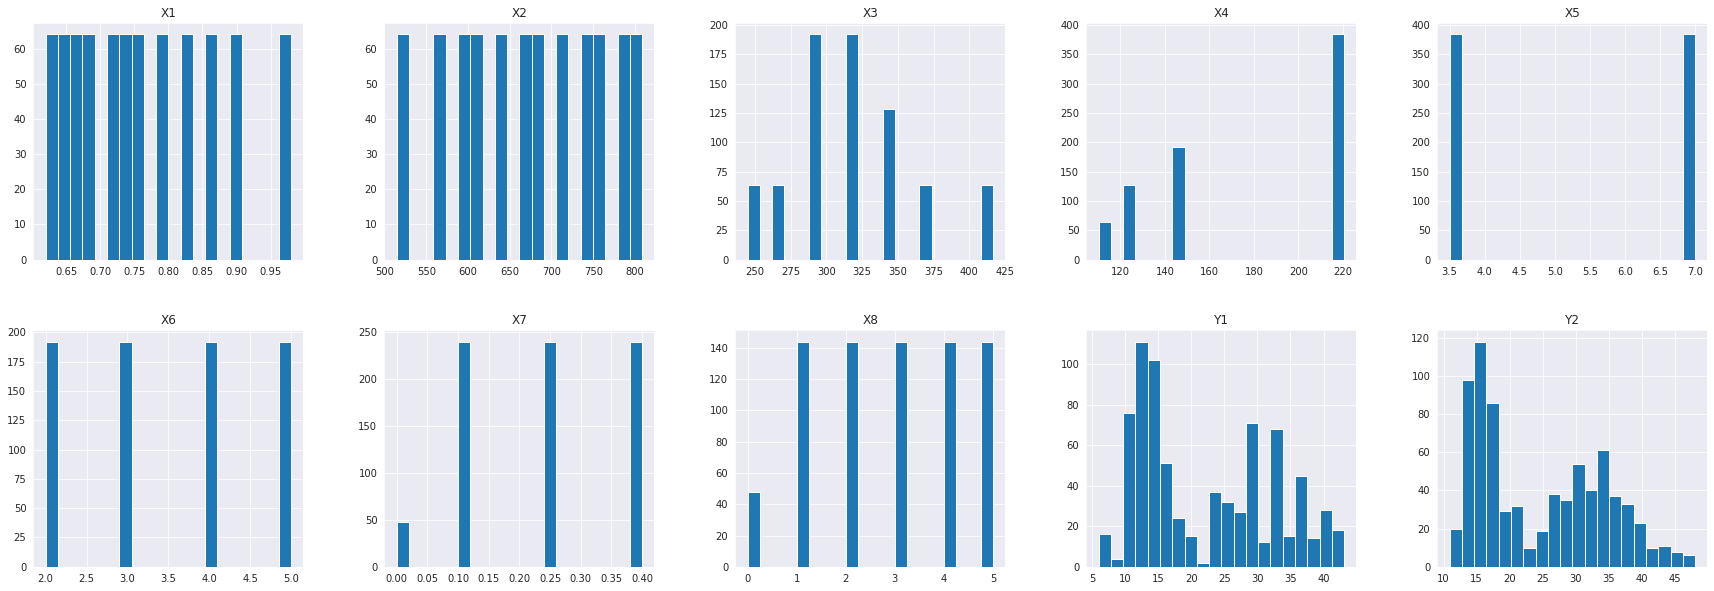

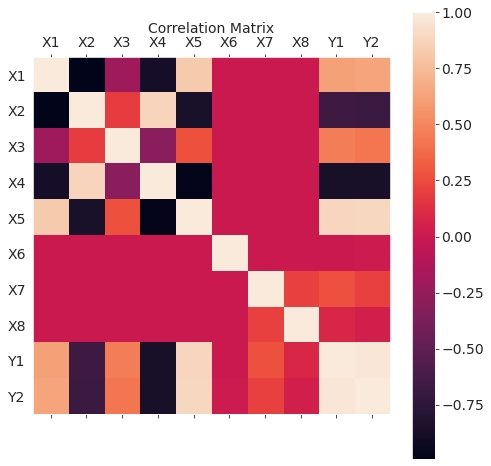

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid",{'axes.grid' : False})

df.hist(layout=(2,5), figsize=(30,10),bins=20)

plt.show()

# plot correlation matrix between features
f = plt.figure(figsize=(8, 8))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=14); 

# Describe the first dataset

Notes:
- No nan values in any column
- Features are already called x_n, y_
- All x features are discrete with varying range
- Both Y are continuous in ~[5, 50]
- X1 and X2 are almost perfectly negatively correlated, r~=-1
- X4 and X5 are highly negatively correlated, r<-0.9

Because features are so highly correlated, we are going to remove the second feature where pearson correlation is greater than 0.95 or less than -0.95.

# Remove highly correlated features from first dataset + standardize

In [3]:
import numpy as np

# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95) and column[0]!='Y']

# dropped features because the analytical solution failed with numpy error
# Drop features 
df = df.drop(to_drop, axis=1)

# standardize each column
df=(df-df.mean(axis=0))/df.std(axis=0)

print(f"Features Dropped: {', '.join(to_drop)}")

Features Dropped: X2, X5


#Analyse and process the second dataset

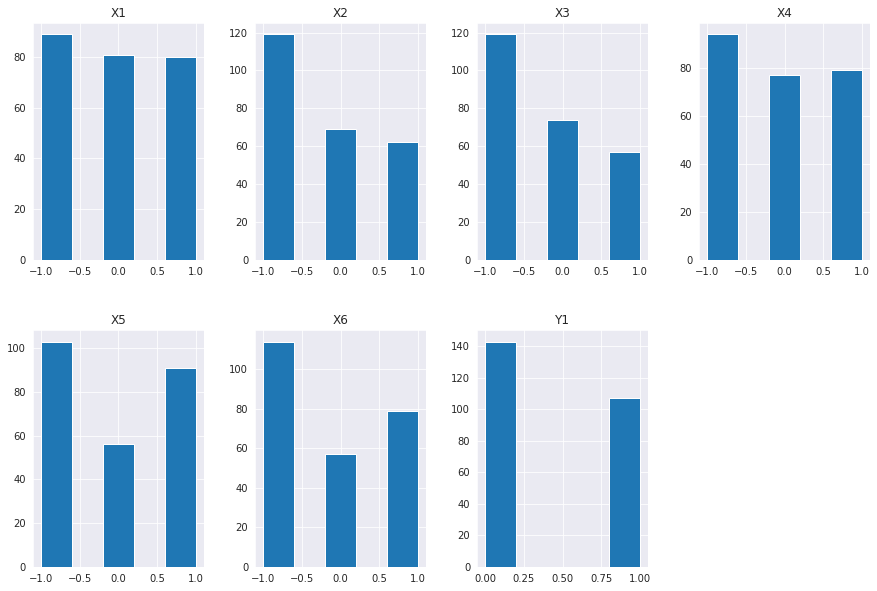

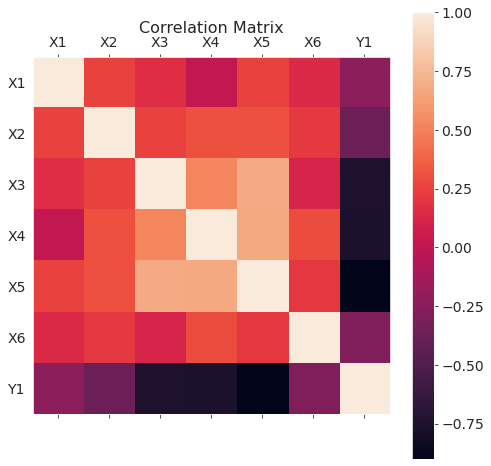

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# mapper for x-columns from categorical to numerical
X_MAPPER = {'P':1, 'A': 0, 'N':-1}
Y_MAPPER = {'B':1, 'NB': 0}

x_columns = list(filter(lambda x: x.startswith('X'), df2.columns))
y_columns = list(filter(lambda x: x.startswith('Y'), df2.columns))

df2.loc[:,x_columns] = df2.loc[:, x_columns].replace(X_MAPPER)
df2.loc[:,y_columns] = df2.loc[:, y_columns].replace(Y_MAPPER)

df2 = df2.astype(int)

sns.set_style("darkgrid",{'axes.grid' : False})

df2.hist(layout=(2,4),figsize=(15,10),bins=5)

# plot correlation matrix between features
f = plt.figure(figsize=(8, 8))
plt.matshow(df2.corr(), fignum=f.number)
plt.xticks(range(df2.select_dtypes(['number']).shape[1]), df2.select_dtypes(['number']).columns, fontsize=14)
plt.yticks(range(df2.select_dtypes(['number']).shape[1]), df2.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);


#Describe the second dataset

- First step is to use the information we have provided from the data to encode the data

- For each of the attributes, they have a category of positive, negative or average, therefore the best encoding is probably {-1, 0, 1} for each x feature

- For the y labels, we are going to set 1 for bankruptcy and 0 for non-bankruptcy
- None of the features are highly correlated, so none of them will be dropped

# Define Batch Gradient Descent

In [5]:

from numpy import random

class BatchGradientDescent:
    
    def __init__(self, batch_size=None, learning_rate=.001, max_iters=1e4, epsilon=1e-8, record_history=False):
        # if batch size is none, uses the whole training set to update gradient
        # otherwise, chooses random batch_size samples from training set
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon

        #to store the history for visualization
        self.history = {'train_cost':[], 'test_cost':[], 'gradient':[]}
            
    def run(self, gradient_fn, x, y, w, cost_fn=None, x_test=None, y_test=None):
        # decorate our gradient function, so we can do mini-batch updates
        self.index = np.arange(x.shape[0])

        grad = np.inf
        t = 1
        iteration = 0
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            # get batch for each gradient update
            #x_grad, y_grad = self.get_batch(x, y)
            x_grad, y_grad = self.get_batch(x, y)

            # [0.4, 0.5..., .1] <- len(w)
            grad = gradient_fn(x_grad, y_grad, w)               # compute the gradient with present weight
            w = w - self.learning_rate * grad         # weight update step
            if self.record_history:
                self.__update_history(grad, x, y, w, cost_fn, x_test, y_test)
            t += 1
            iteration += 1
        return w


    def __update_history(self, grad, x, y, w, cost_fn, x_test, y_test):
      # track the mean gradient accross all the parameters
      self.history['gradient'].append(np.mean(grad))

      # only try to add the training cost to history
      # if a cost function is provided
      if cost_fn:
        train_cost = cost_fn(y, x@w)
        self.history['train_cost'].append(train_cost)

        if (x_test is not None) and (y_test is not None):
          test_cost = cost_fn(y_test, x_test @ w)
          self.history['test_cost'].append(test_cost)


    def get_batch(self, x, y):
        """this functions purpose is to convert inputs x, y 
        into random batch of batch_size for gradient update. 
        """
        if not self.batch_size:
          return x, y

        _i = random.choice(self.index, self.batch_size)
        return x[_i], y[_i]


# Define Linear Regresssion Model

In [6]:
import numpy as np
import copy

class LinearRegression:
    def __init__(self, optimizer=None, add_bias=True):
      # deep copy because optimizer is an object,
      # and we need to use the same one multiple
      # times for validation + experiments
      self.optimizer = copy.deepcopy(optimizer)
      self.add_bias = add_bias
    
    def fit(self, x, y, x_test=None, y_test=None):

      if x.ndim == 1:
          x = x[:, None]                         #add a dimension for the features
    
      if x_test is not None:
          if x_test.ndim==1:
            x_test = x_test[:, None]

      if self.add_bias:
          x = np.column_stack([x,np.ones(x.shape[0])])
          
          # also add w0 to test 
          if x_test is not None:
            x_test = np.column_stack([x_test, np.ones(x_test.shape[0])])

      # solve numerically if given 
      if self.optimizer:
        self.w = self.__numerical(x, y, x_test, y_test)
      else:
        self.w = self.__analytical(x, y)

      return self

    def __analytical(self, x, y):
      return  np.linalg.inv(x.T @ x)@x.T@y 

    def __numerical(self, x, y, x_test, y_test):
      zeros = np.zeros(x.shape[1]) 
      return self.optimizer.run(self.gradient, x, y, zeros, self.cost, x_test, y_test)   #CHANGE

    def predict(self, x):
      N = x.shape[0]
      if self.add_bias:
          x = np.column_stack([x,np.ones(N)])
      yh = x@self.w                             #predict the y values
      return yh

    @staticmethod
    def gradient(x, y, w):                          # define the gradient function
      yh =  x @ w
      N, D = x.shape
      grad = .5*np.dot(yh.squeeze() - y.squeeze(), x)/N
      return grad

    @staticmethod
    def cost(y, y_hat):
      return .5*np.mean((y_hat.squeeze() - y.squeeze())**2)   

# Define Logistic Regression Model

In [7]:
import numpy as np
import copy

class LogisticRegression:
    
    def __init__(self, optimizer, add_bias=True):
        self.add_bias = add_bias
        self.optimizer = copy.deepcopy(optimizer)
        
    def fit(self, x, y_unsafe, x_test=None, y_test=None):
        # have to flatten
        y = y_unsafe.flatten()

        if x.ndim == 1:
            x = x[:, None]
            if x_test is not None:
              x_test = x_test[:, None]

        if self.add_bias:
            x = np.column_stack([x,np.ones(x.shape[0])])
            if x_test is not None:
              x_test = np.column_stack([x_test, np.ones(x_test.shape[0])])

        N,D = x.shape

        zeros = np.zeros(D) 
        self.w = self.optimizer.run(self.gradient, x, y, zeros, self.cost, x_test, y_test) #CHANGE
        return self
    
    def predict(self, x):
        logistic = lambda z: 1./ (1 + np.exp(-z))
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

    @staticmethod
    def gradient(x, y, w):
      logistic = lambda z: 1./ (1 + np.exp(-z))
      N,D = x.shape
      yh = logistic(np.dot(x, w))    # predictions  size N
      grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
      return grad                         # size D

    @staticmethod
    def cost(y, y_hat):   
      y=y.squeeze()
      y_hat=y_hat.squeeze()                                                
      J = np.mean(y * np.log1p(np.exp(-y_hat)) + (1-y) * np.log1p(np.exp(y_hat)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
      return J


# Define Cross Validation

In [8]:
import numpy as np
from numpy import random
from copy import deepcopy
from abc import ABC, abstractmethod

class CrossValidation(ABC):

  def __init__(self, model:object):
    self.model = model

  @abstractmethod
  def split(self, X, Y):
    """must take x and y as arguments and return iterable
    with each index as indexes for test set at point n
    """
    pass
    
  def train(self, X_train:np.ndarray, y_train:np.ndarray, X_test:np.ndarray, y_test:np.ndarray):
    model = copy.deepcopy(self.model)
    model.fit(X_train, y_train, X_test, y_test)
    return model

  def run(self, X:np.ndarray, y:np.ndarray):
    """run cross validation and return 3 dataframes 
    1. cost over each fold for test + train dataset
    2. predictions and real values for each fold in train + test
    3. final weights for each fold of training
    """
    # init the tracking 
    self.__init_tracking()

    len = X.shape[0]
    

    for i, test_idx in enumerate(self.split(X, y)):
        X_test = X[test_idx]
        X_train = X[np.delete(np.arange(len),test_idx)]
        y_test = y[test_idx]
        y_train =  y[np.delete(np.arange(len),test_idx)]

        model = self.train(X_train, y_train, X_test, y_test)
        self.model_list.append(model)
        self.prep_metrics(i+1, model, X_train, X_test, y_train, y_test)

    return self.df(self.results), self.df(self.predictions), self.cast_weights(self.weights)

  def prep_metrics(self, i:int, model:object, X_train:np.ndarray, X_test:np.ndarray, y_train:np.ndarray, y_test:np.ndarray):
    """Iterate over training and testing data and predicts, computes cost and other metrics
    and adds to dataframes so that we can track model performance over different folds and
    training and testing dataset
    """
    
    # add weights to history
    self.weights.append(model.w.flatten().tolist())

    if hasattr(model.optimizer, 'history'):
      self.history[i] = model.optimizer.history.copy()

    # iterate over training and testing data 
    # note that we already trained the model, now we are just predicting 
    for title, X, y in [('train', X_train, y_train), ('test',X_test, y_test)]:

      y_hat = model.predict(X)
      cost = model.cost(y, y_hat)

      # add to results
      self.results['fold'].append(i)
      self.results['cost'].append(cost)
      self.results['dataset'].append(title)

      # add to predictions
      self.predictions['y'].extend(y.flatten().tolist())
      self.predictions['dataset'].extend([title]*len(y))
      self.predictions['fold'].extend([i]*len(y))

      # threshold if we are using logistic regression
      if isinstance(self.model, LogisticRegression):
        y_hat = y_hat >= 0.5
      
      self.predictions['y_hat'].extend(y_hat.flatten().tolist())

  def df(self, data):
    return pd.DataFrame(data)

  def cast_weights(self, data):
    # more work to convert data to pivot table
    cols = list(map(lambda x: f"w{x}", np.arange(len(data[0]))))
    df = pd.DataFrame(data, columns=cols)
    sign = dict(zip(cols, np.sign(df.mean(axis=0))))
    df = df.abs()
    df['fold'] = df.index.values
    df = pd.melt(df, id_vars=['fold'], value_vars=cols, var_name='weight')
    df['sign'] = df['weight'].map(sign)
    return df

  def __init_tracking(self):
      self.results = {'cost':[],'dataset':[],'fold':[]}
      self.predictions = {'y_hat':[], 'y':[],'dataset':[],'fold':[]}
      self.weights = []
      self.history = {}
      self.model_list=[]


In [9]:
from prompt_toolkit.output.base import abstractmethod
import numpy as np
from numpy import random
import copy


class KFoldValidation(CrossValidation):
  # note that k=5 is equivalent to 80% training
  # ([4/5], [1/5]) * 5
  def __init__(self, model:object, k:int=5, test_frac:float=None):
    super(KFoldValidation, self).__init__(model)

    if test_frac:
      self.k = round(1/test_frac)
    else:
      self.k = k

  def split(self, X:np.ndarray, y:np.ndarray):
    if X.shape[0]!=y.shape[0]:
      raise Exception("arrays of unequal length")

    index = np.arange(y.shape[0])
    random.seed(10)
    random.shuffle(index)

    return np.array_split(index,self.k)


# Experiments, Round 1 

### Train, analyze weights

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:675: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1080x576 with 0 Axes>

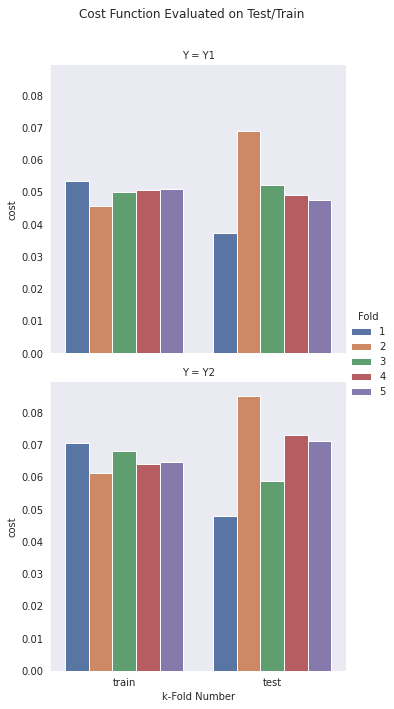

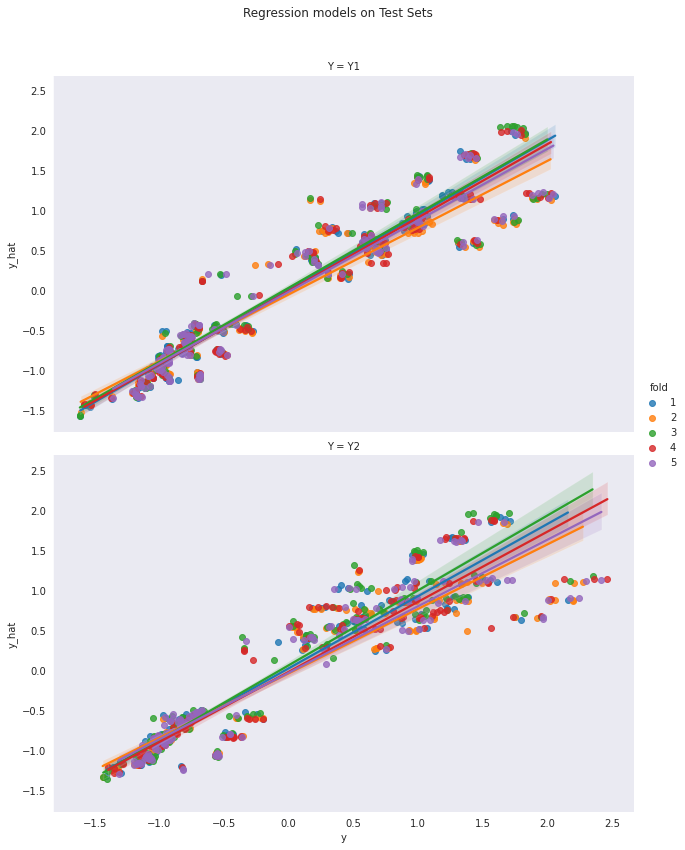

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:675: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1080x576 with 0 Axes>

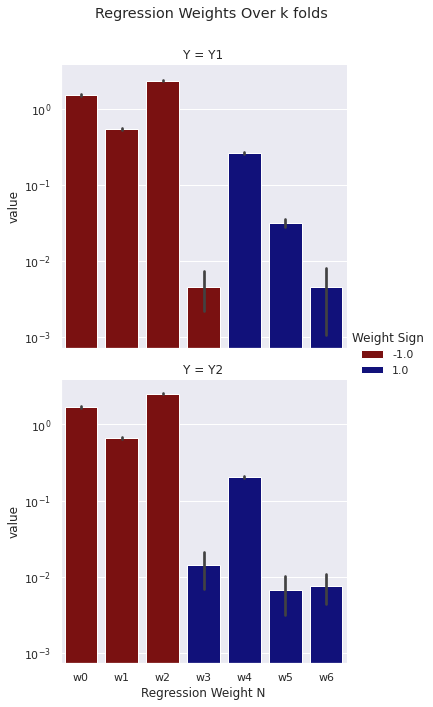

In [10]:
import seaborn as sns
from copy import deepcopy

linreg = LinearRegression()
crossval = KFoldValidation(linreg)

x_columns = list(filter(lambda x: x.startswith('X'), df.columns))
y_columns = list(filter(lambda x: x.startswith('Y'), df.columns))

X = df.loc[:,x_columns].values
Y = df.loc[:,y_columns].values

#Run the cross validation on both labels Y0 and Y1
results_Y0, predictions_Y0, weights_Y0 = crossval.run(X, Y[:,0])
results_Y1, predictions_Y1, weights_Y1 = crossval.run(X, Y[:,1])

# concat into single df for barplot
results_Y0['Y'] = "Y1"
results_Y1['Y'] = "Y2"
results = pd.concat([results_Y0, results_Y1])

# plot the cost function over each fold
sns.set_style("darkgrid",{'axes.grid' : False})
plt.figure(figsize=(15,8))
g=sns.FacetGrid(data=results, row="Y", height=5)
g.map(sns.barplot, 'dataset','cost', 'fold', palette='deep')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Cost Function Evaluated on Test/Train')
plt.xlabel('k-Fold Number')
g.add_legend(title='Fold')
plt.show()

# concat into single df for barplot
predictions_Y0['Y'] = "Y1"
predictions_Y1['Y'] = "Y2"
predictions = pd.concat([predictions_Y0, predictions_Y1])
predictions = predictions[predictions['dataset']=='test']

# plot the regression (for Y0)
g = sns.lmplot(data=predictions, x="y", y="y_hat", hue='fold', height=6, aspect=1.5, row='Y')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Regression models on Test Sets')

plt.show()

print('\n')

weights_Y0['Y'] = "Y1"
weights_Y1['Y'] = "Y2"
weights = pd.concat([weights_Y0, weights_Y1]).reset_index(drop=True)

# plot weights (for Y0)
sns.set_theme()
plt.figure(figsize=(15,8))
g=sns.FacetGrid(data=weights, row="Y", height=5)
g.map(sns.barplot,'weight','value','sign', palette=['darkred','darkblue'], order=['w0','w1','w2','w3','w4','w5','w6'], dodge=False)
g.set(yscale='log')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Regression Weights Over k folds')
plt.xlabel('Regression Weight N')
g.add_legend(title='Weight Sign')
plt.show()



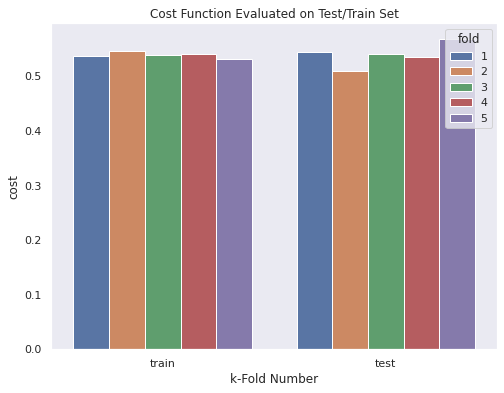

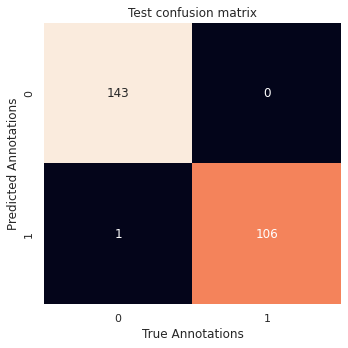

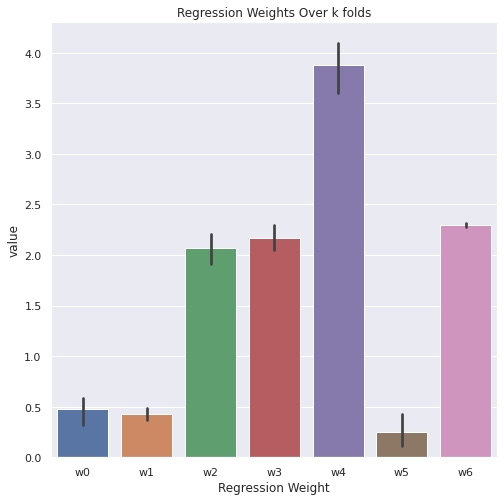

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

optimizer = BatchGradientDescent(batch_size=2, learning_rate=.1, epsilon=1e-4, max_iters=1e4)
logreg = LogisticRegression(optimizer)
crossval = KFoldValidation(logreg)

x_columns = list(filter(lambda x: x.startswith('X'), df2.columns))
y_columns = list(filter(lambda x: x.startswith('Y'), df2.columns))

X = df2.loc[:,x_columns].values
Y = df2.loc[:,y_columns].values

results, predictions, weights = crossval.run(X, Y)

# plot the cost function over each fold
sns.set_style("darkgrid",{'axes.grid' : False})
plt.figure(figsize=(8,6))
sns.barplot(data=results, x='dataset', y='cost', hue='fold', palette='deep')
plt.xlabel('k-Fold Number')
plt.title('Cost Function Evaluated on Test/Train Set')
plt.show()

# plot the regression
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

data = predictions[predictions['dataset']=='test']
cf_matrix = confusion_matrix(data['y'], data['y_hat'])
fig = sns.heatmap(cf_matrix, annot=True, ax=ax, fmt='.0f', cbar=False)
ax.set_ylabel('Predicted Annotations')
ax.set_xlabel('True Annotations')
ax.title.set_text('Test Confusion Matrix'.capitalize())
plt.tight_layout()  
plt.show()


# plot weights
sns.set_theme()
plt.figure(figsize=(8,8))
k = sns.barplot(data=weights, x='weight', y='value')
plt.xlabel('Regression Weight')
plt.title('Regression Weights Over k folds')
plt.show()


# Experiments, Round 2

### Model performance vs train/test split

In [12]:
from numpy import random 

class BootstrapValidation(CrossValidation):
  """same method of running experiment as k fold
  validation, except test set is sub-sampled each
  time without replacement, meaning same value can
  show up in multiple testing sets
  """
  
  def __init__(self, model, test_frac, n_times=5):
    super(BootstrapValidation, self).__init__(model)

    # fraction of data held aside for testing
    self.test_frac = test_frac

    # want to repeat dataset n times to get error bounds
    # even if our test set is 90%
    self.n_times = n_times

  def split(self, X, y):
    self.test_size = round(X.shape[0]*self.test_frac)

    # because we have specified that we want to repeat 
    # data n times, need m folds of test size k
    self.n_folds = round(X.shape[0]*self.n_times/self.test_size)
    
    index = np.arange(X.shape[0])
    return [random.choice(index, (self.test_size,)) for _ in range(self.n_folds)]

In [13]:
import itertools
import numpy as np
from copy import deepcopy

class Experiment:
  """experiment class is for testing out diferent combinations of test fraction,
  batch size and learning rate
  """

  def __init__(self, model, optimizer=None, validation=BootstrapValidation, 
               test_fracs=[0.2], batch_sizes=[None], learning_rates=[0.1]):
    
    # un-initialized model
    self.model = deepcopy(model)

    # want un-initialized optimizer, because we are going to pass in
    # the batch size, learning rate, etc that we have provided here.
    # other paramters that are not default should be added to the 
    # class via functools.partial
    self.optimizer = deepcopy(optimizer)

    # un-initialized class
    self.validation = deepcopy(validation)

    self.test_fracs = test_fracs
    self.batch_sizes = batch_sizes
    self.learning_rates = learning_rates

    self.results = []
    self.training_history = []
    self.model_list = []

  @property
  def parameters(self):
    return itertools.product(self.test_fracs, self.batch_sizes, self.learning_rates)

  def run(self, X, Y):
    """iterate over all combinations of the test_frac, batch_size and 
    learning rate that we have, and run cross validation at each fold. 
    combine the results into dataframes with the parameters used.
    
    returns two dataframes
    1. final cost for training and testing, with all the folds of validation
    separate and the test_frac, batch_size, learning_rate etc

    2. training and testing cost over each step in the gradient descent. 
    this allows us to visualize the training curve. also includes the actual
    gradient at each step, and has all the folds separate
    """
    for tf_i, bs_i, lr_i in self.parameters:
      # if we have an optimizer, assign here
      if self.optimizer:
        optimizer = self.optimizer(batch_size=bs_i, learning_rate=lr_i)
      else:
        optimizer = None

      model = deepcopy(self.model)(optimizer)
      crossval = deepcopy(self.validation)(model, test_frac=tf_i)

      results, _, _ = crossval.run(X, Y)
      results['test_frac'] = tf_i
      results['batch_size'] = bs_i
      results['learning_rate'] = lr_i

      self.results.append(results)
      self.model_list.extend(crossval.model_list)

      # extra code for calculating training cost, gradient etc
      learn_list=[]
      learn_df=pd.DataFrame()
      if crossval.history:
        learning = pd.DataFrame(crossval.history.values(),index=crossval.history.keys())
        learn_list=[]
        for key in ['test_cost','train_cost','gradient']:
          df_i = pd.DataFrame(learning[key].to_list())
          df_i['fold'] = df_i.index.values
          df_i['metric'] = key
          learn_list.append(df_i)

        learn_df = pd.concat(learn_list)
        learn_df['test_frac'] = tf_i
        learn_df['batch_size'] = bs_i
        learn_df['learning_rate'] = lr_i
      
      self.training_history.append(learn_df)
      

    return pd.concat(self.results).reset_index(drop=True), pd.concat(self.training_history).reset_index(drop=True)



<Figure size 1080x576 with 0 Axes>

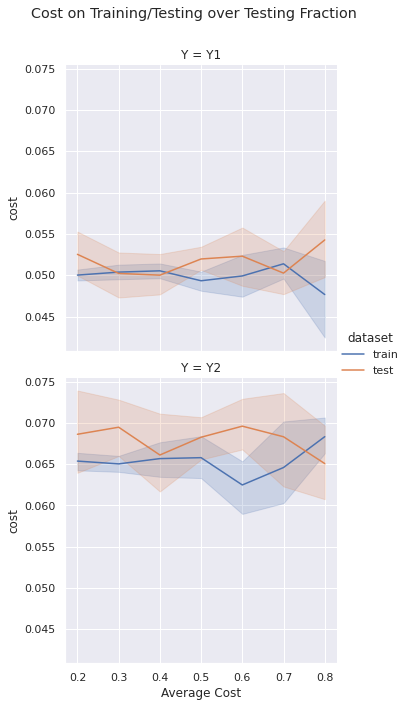

In [14]:
import seaborn as sns
from numpy import random

linreg = LinearRegression
bootval = BootstrapValidation

x_columns = list(filter(lambda x: x.startswith('X'), df.columns))
y_columns = list(filter(lambda x: x.startswith('Y'), df.columns))

X = df.loc[:,x_columns].values
Y = df.loc[:,y_columns].values

test_fracs = np.arange(0.2,0.8,0.1)

experimentY0 = Experiment(linreg, validation=bootval, test_fracs=test_fracs)
experimentY1 = Experiment(linreg, validation=bootval, test_fracs=test_fracs)

#concat problem resultsY1 has resultsY0 stacked on it
resultsY0,_ = experimentY0.run(X, Y[:,0])
resultsY1,_ = experimentY1.run(X, Y[:,1])

resultsY0['Y'] = "Y1"
resultsY1['Y'] = "Y2"
results = pd.concat([resultsY0, resultsY1])

# plot weights (Y0)
sns.set_theme()
plt.figure(figsize=(15,8))
g = sns.relplot(data=results, x='test_frac', y='cost', hue='dataset', row='Y', kind='line')
g.set_xlabels('Testing Fraction')
g.set_xlabels('Average Cost')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Cost on Training/Testing over Testing Fraction')
plt.show()

<Figure size 576x576 with 0 Axes>

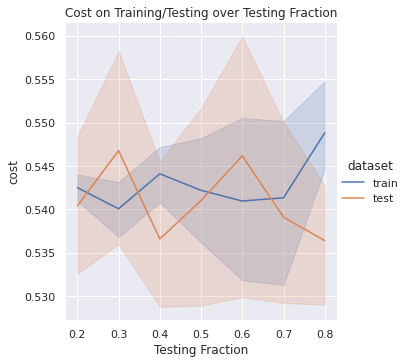

In [15]:
import seaborn as sns
from scipy import stats
from functools import partial

optimizer = partial(BatchGradientDescent, epsilon=1e-4, max_iters=1e3)
logreg = LogisticRegression
bootval = BootstrapValidation

x_columns = list(filter(lambda x: x.startswith('X'), df2.columns))
y_columns = list(filter(lambda x: x.startswith('Y'), df2.columns))

X = df2.loc[:,x_columns].values
Y = df2.loc[:,y_columns].values

test_fracs = np.arange(0.2,0.8,0.1)
experiment = Experiment(logreg, optimizer=optimizer, validation=bootval, test_fracs=test_fracs, learning_rates=[0.1])

results,_ = experiment.run(X, Y)

# plot weights
sns.set_theme()
plt.figure(figsize=(8,8))
sns.relplot(data=results, x='test_frac', y='cost', hue='dataset',aspect=1, kind='line')
plt.xlabel('Testing Fraction')
plt.title('Cost on Training/Testing over Testing Fraction')
plt.show()

# Experiment, Round 3

### Test out different minibatch sizes

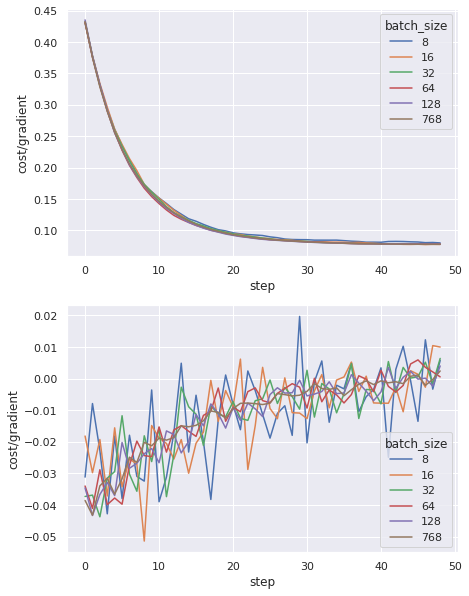

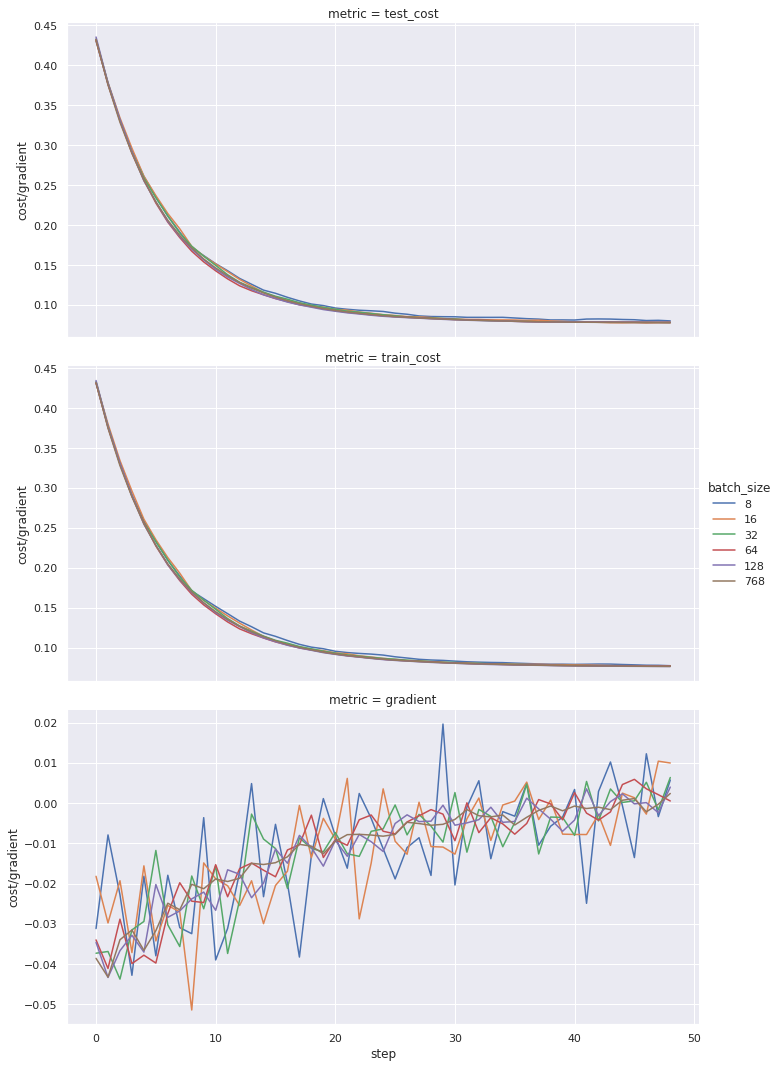

/n


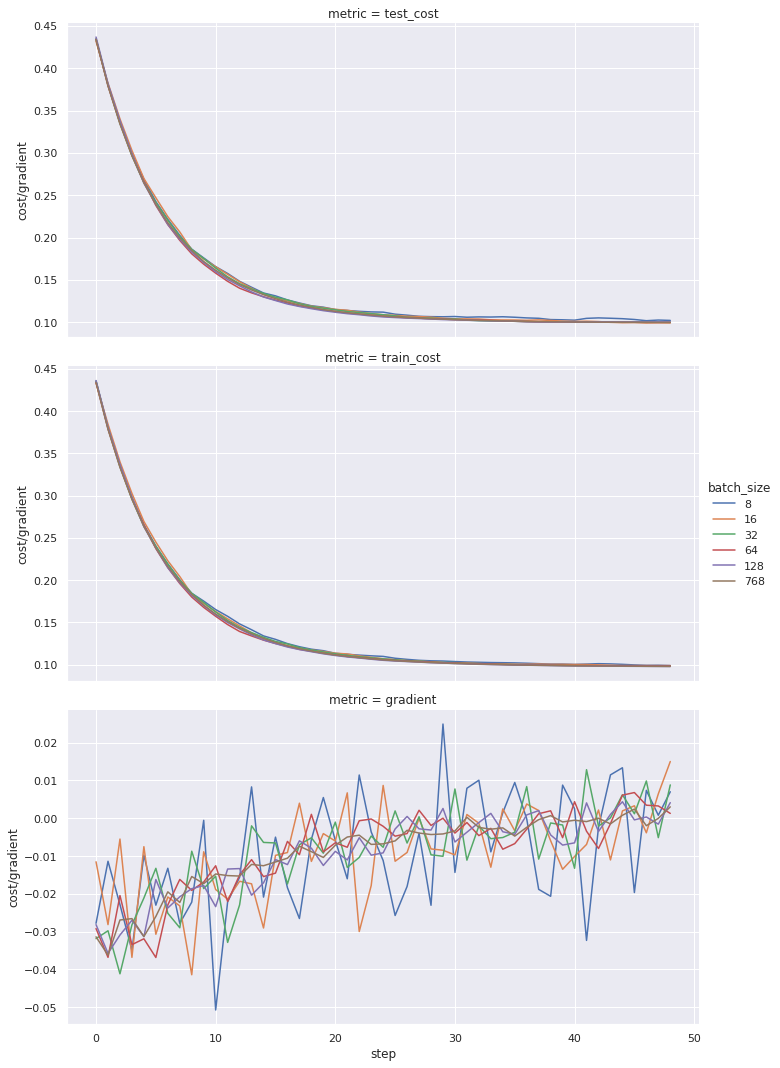

In [16]:
import seaborn as sns
from numpy import random


optimizer = partial(BatchGradientDescent, epsilon=1e-4, max_iters=50, record_history=True)
linreg = LinearRegression
kfoldval = KFoldValidation

x_columns = list(filter(lambda x: x.startswith('X'), df.columns))
y_columns = list(filter(lambda x: x.startswith('Y'), df.columns))

X = df.loc[:,x_columns].values
Y = df.loc[:,y_columns].values

experiment1 = Experiment(linreg, optimizer=optimizer, validation=kfoldval, learning_rates=[0.1], test_fracs=[0.2], batch_sizes=[8, 16, 32, 64, 128, len(X)])#1e-3,1e-4,1e-5]) #64 best for now
experiment2 = Experiment(linreg, optimizer=optimizer, validation=kfoldval, learning_rates=[0.1], test_fracs=[0.2], batch_sizes=[8, 16, 32, 64, 128, len(X)])#1e-3,1e-4,1e-5])


# (cost at all steps), (cost_at_each_step) (For both Y0 and Y1)
results_Y0, training_Y0 = experiment1.run(X, Y[:,0])
results_Y1, training_Y1 = experiment2.run(X, Y[:,1])

# plot weights (Y0)
numeric = list(filter(lambda x: isinstance(x, int), training_Y0.columns))
non_numeric = list(set(training_Y0.columns)-set(numeric))
training_Y0 = pd.melt(training_Y0, id_vars=non_numeric, value_vars=numeric, ignore_index=False,value_name='cost/gradient', var_name='step').reset_index(drop=True)

sns.set_theme()

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
sns.lineplot(data=training_Y0[training_Y0['metric']=='test_cost'], x='step', y='cost/gradient', hue='batch_size', palette = 'deep',ci=None,ax=ax1)
sns.lineplot(data=training_Y0[training_Y0['metric']=='gradient'], x='step', y='cost/gradient', hue='batch_size', palette = 'deep',ci=None,ax=ax2)
plt.show()


facet_kws={'sharey': False, 'sharex': True}
g = sns.relplot(data=training_Y0, x='step', y='cost/gradient', hue='batch_size', palette = 'deep', height=5,aspect=2,  kind="line",  row="metric",facet_kws=facet_kws,ci=None)
plt.show()

print('/n')

# plot weights (Y1)
numeric = list(filter(lambda x: isinstance(x, int), training_Y1.columns))
non_numeric = list(set(training_Y1.columns)-set(numeric))
training_Y1 = pd.melt(training_Y1, id_vars=non_numeric, value_vars=numeric, ignore_index=False,value_name='cost/gradient', var_name='step').reset_index(drop=True)

sns.set_theme()
facet_kws={'sharey': False, 'sharex': True}
g = sns.relplot(data=training_Y1, x='step', y='cost/gradient', hue='batch_size', palette='deep', height=5,aspect=2,  kind="line",  row="metric",facet_kws=facet_kws,ci=None)
plt.show()


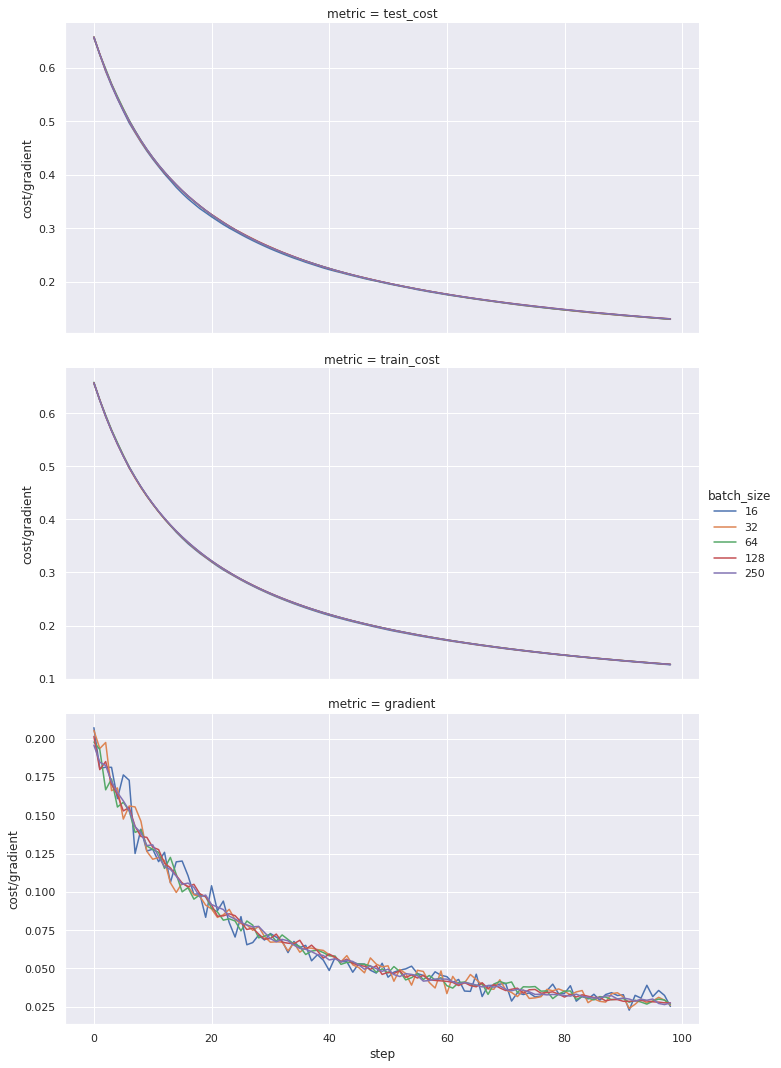

In [17]:
import seaborn as sns
from numpy import random

optimizer = partial(BatchGradientDescent, epsilon=1e-4, max_iters=1e2, record_history=True)
logreg = LogisticRegression
kfoldval = KFoldValidation

x_columns = list(filter(lambda x: x.startswith('X'), df2.columns))
y_columns = list(filter(lambda x: x.startswith('Y'), df2.columns))

X = df2.loc[:,x_columns].values
Y = df2.loc[:,y_columns].values

experiment = Experiment(logreg, optimizer=optimizer, validation=kfoldval, learning_rates=[0.1], test_fracs=[0.2], batch_sizes=[16, 32, 64, 128, len(X)]) #16 best

results, training = experiment.run(X, Y)

# plot weights
numeric = list(filter(lambda x: isinstance(x, int), training.columns))
non_numeric = list(set(training.columns)-set(numeric))
training = pd.melt(training, id_vars=non_numeric, value_vars=numeric, ignore_index=False,value_name='cost/gradient', var_name='step').reset_index(drop=True)

sns.set_theme()
facet_kws={'sharey': False, 'sharex': True}
g = sns.relplot(data=training, x='step', y='cost/gradient', hue='batch_size', palette='deep',height=5,aspect=2, kind="line", row="metric",facet_kws=facet_kws,ci=None)
plt.show()




#Experiment, Round 4
###Test out different learning rates



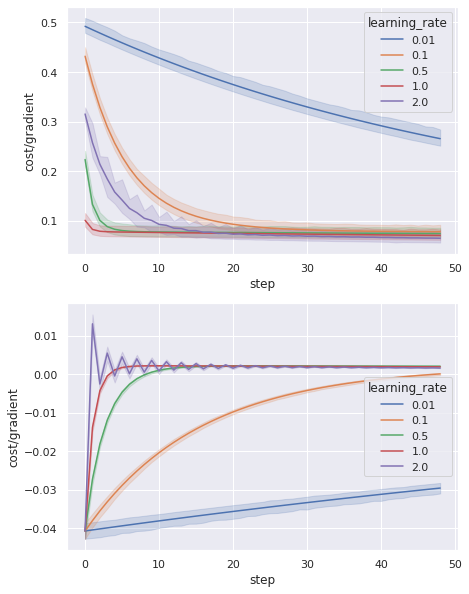

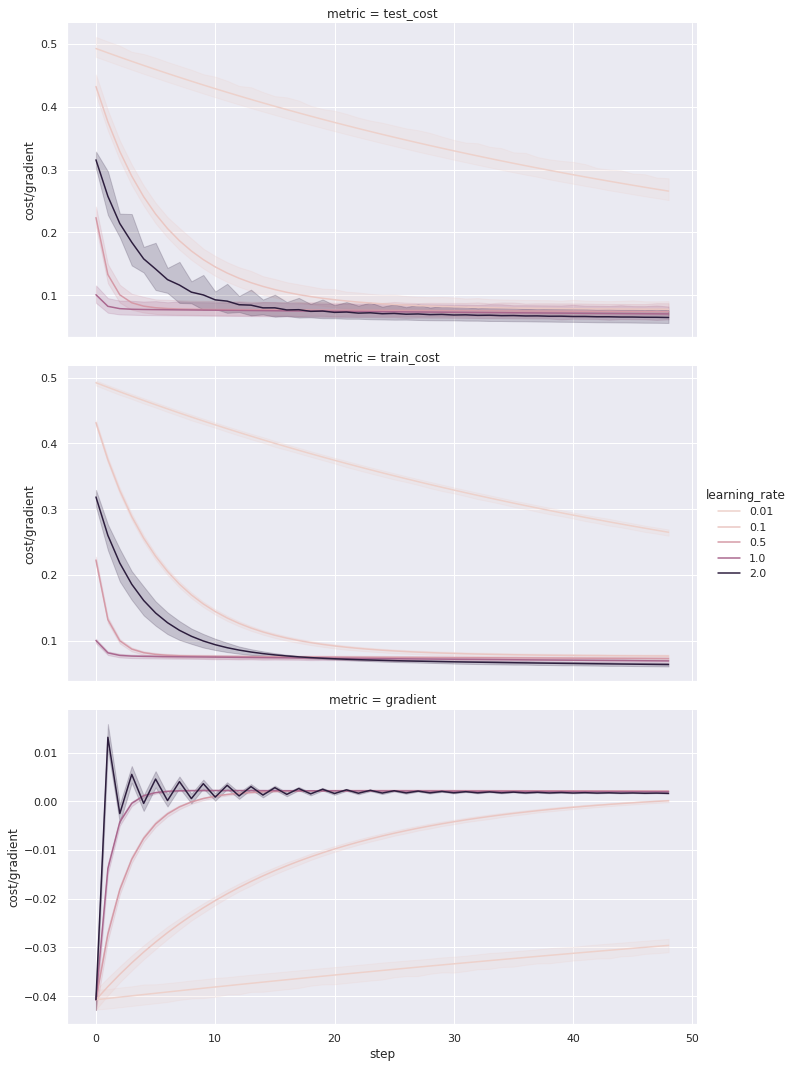

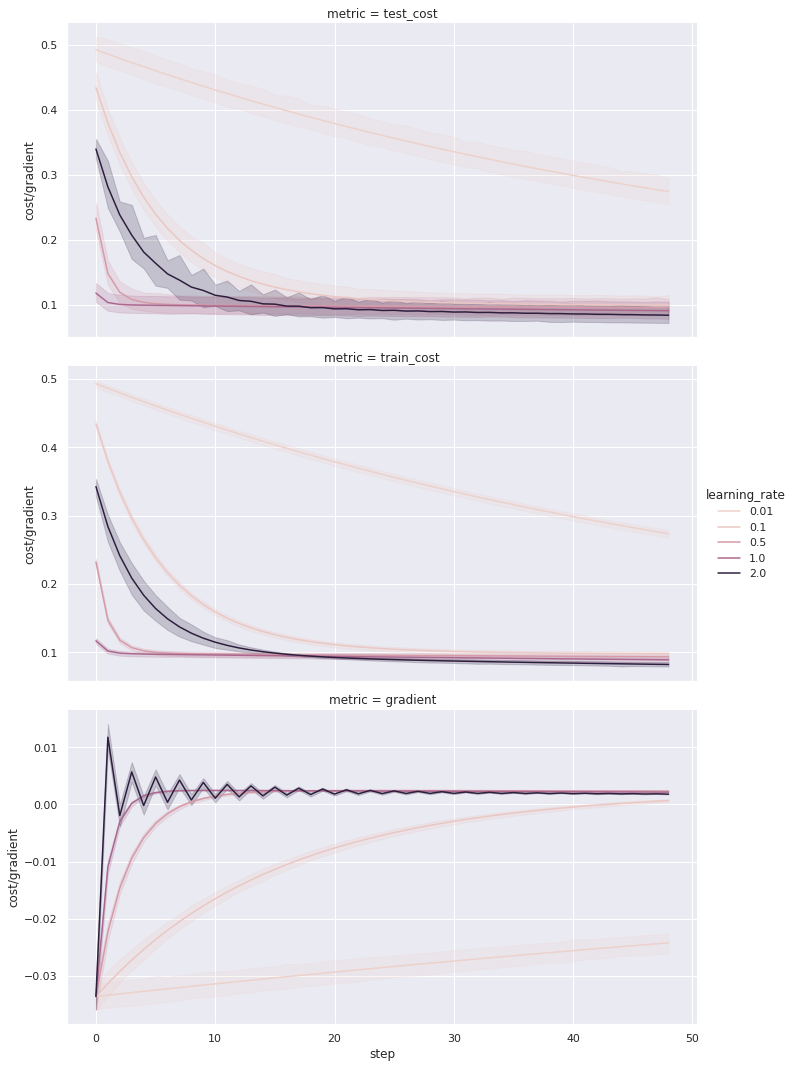

In [18]:
import seaborn as sns
from numpy import random


optimizer = partial(BatchGradientDescent, epsilon=1e-4, max_iters=50, record_history=True)
linreg = LinearRegression
kfoldval = KFoldValidation

x_columns = list(filter(lambda x: x.startswith('X'), df.columns))
y_columns = list(filter(lambda x: x.startswith('Y'), df.columns))

X = df.loc[:,x_columns].values
Y = df.loc[:,y_columns].values

experiment1 = Experiment(linreg, optimizer=optimizer, validation=kfoldval, learning_rates=[0.01,0.1,0.5,1,2], test_fracs=[0.2], batch_sizes=[None])#1e-3,1e-4,1e-5])
experiment2 = Experiment(linreg, optimizer=optimizer, validation=kfoldval, learning_rates=[0.01,0.1,0.5,1,2], test_fracs=[0.2], batch_sizes=[None])#1e-3,1e-4,1e-5])


# (cost at all steps), (cost_at_each_step) (For both Y0 and Y1)
results_Y0, training_Y0 = experiment1.run(X, Y[:,0])
results_Y1, training_Y1 = experiment2.run(X, Y[:,1])

# plot weights (Y0)
numeric = list(filter(lambda x: isinstance(x, int), training_Y0.columns))
non_numeric = list(set(training_Y0.columns)-set(numeric))
training_Y0 = pd.melt(training_Y0, id_vars=non_numeric, value_vars=numeric, ignore_index=False,value_name='cost/gradient', var_name='step').reset_index(drop=True)

sns.set_theme()

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
sns.lineplot(data=training_Y0[training_Y0['metric']=='test_cost'], x='step', y='cost/gradient', hue='learning_rate', palette = 'deep',ax=ax1)
sns.lineplot(data=training_Y0[training_Y0['metric']=='gradient'], x='step', y='cost/gradient', hue='learning_rate', palette = 'deep',ax=ax2)
plt.show()

facet_kws={'sharey': False, 'sharex': True}
g = sns.relplot(data=training_Y0, x='step', y='cost/gradient', hue='learning_rate', height=5,aspect=2,  kind="line",  row="metric",facet_kws=facet_kws)
plt.show()


# plot weights (Y1)
numeric = list(filter(lambda x: isinstance(x, int), training_Y1.columns))
non_numeric = list(set(training_Y1.columns)-set(numeric))
training_Y1 = pd.melt(training_Y1, id_vars=non_numeric, value_vars=numeric, ignore_index=False,value_name='cost/gradient', var_name='step').reset_index(drop=True)

sns.set_theme()
facet_kws={'sharey': False, 'sharex': True}
g = sns.relplot(data=training_Y1, x='step', y='cost/gradient', hue='learning_rate', height=5,aspect=2,  kind="line",  row="metric",facet_kws=facet_kws)
plt.show()


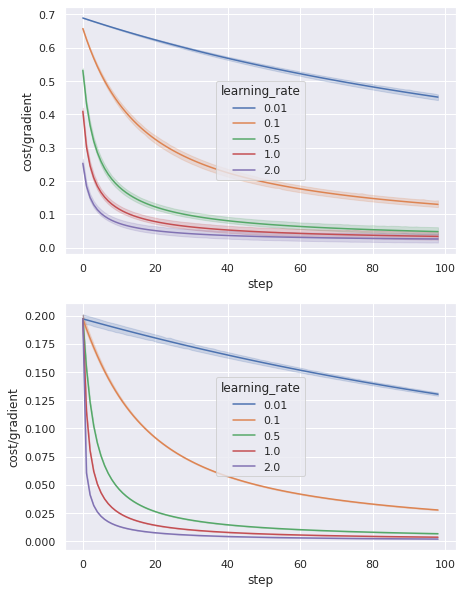

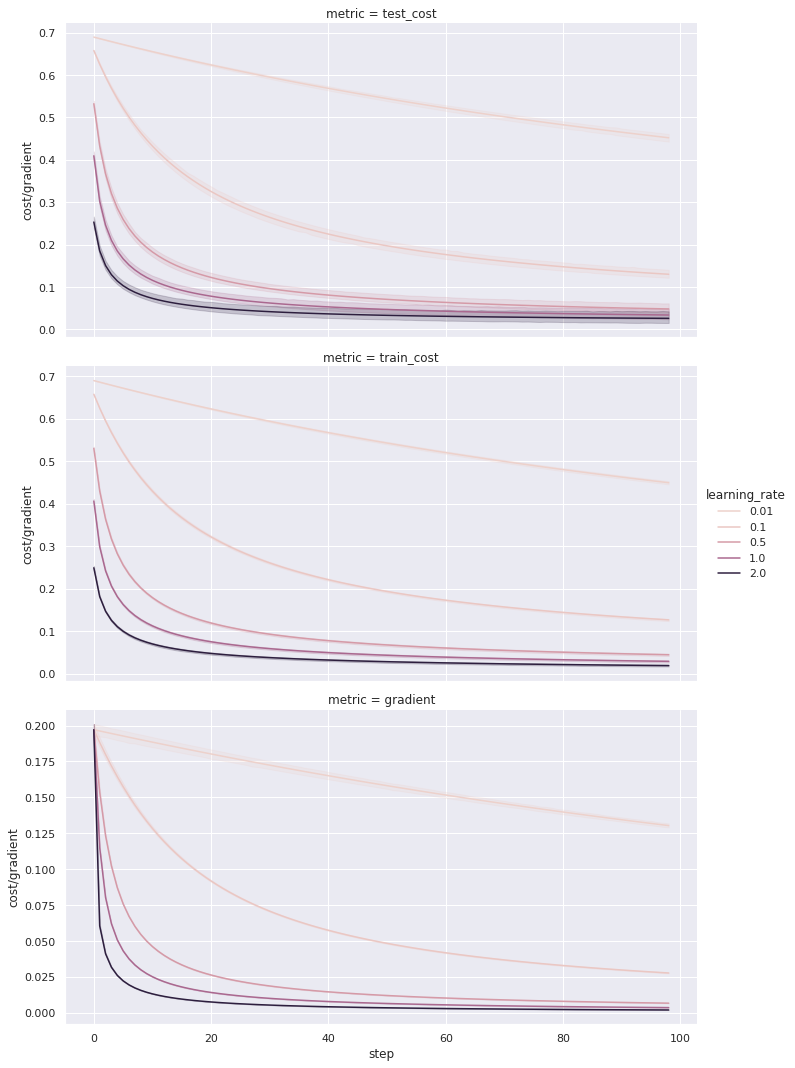

In [19]:
import seaborn as sns
from numpy import random

optimizer = partial(BatchGradientDescent, epsilon=1e-4, max_iters=1e2, record_history=True)
logreg = LogisticRegression
kfoldval = KFoldValidation

x_columns = list(filter(lambda x: x.startswith('X'), df2.columns))
y_columns = list(filter(lambda x: x.startswith('Y'), df2.columns))

X = df2.loc[:,x_columns].values
Y = df2.loc[:,y_columns].values

experiment = Experiment(logreg, optimizer=optimizer, validation=kfoldval, learning_rates=[0.01,0.1,0.5,1,2], test_fracs=[0.2], batch_sizes=[None])

results, training = experiment.run(X, Y)


# plot weights
numeric = list(filter(lambda x: isinstance(x, int), training.columns))
non_numeric = list(set(training.columns)-set(numeric))
training = pd.melt(training, id_vars=non_numeric, value_vars=numeric, ignore_index=False,value_name='cost/gradient', var_name='step').reset_index(drop=True)

sns.set_theme()

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
sns.lineplot(data=training[training['metric']=='test_cost'], x='step', y='cost/gradient', hue='learning_rate', palette = 'deep',ax=ax1)
sns.lineplot(data=training[training['metric']=='gradient'], x='step', y='cost/gradient', hue='learning_rate', palette = 'deep',ax=ax2)
plt.show()

facet_kws={'sharey': False, 'sharex': True}
g = sns.relplot(data=training, x='step', y='cost/gradient', hue='learning_rate', height=5,aspect=2,  kind="line",  row="metric",facet_kws=facet_kws)
plt.show()

#Experiment Round 4

###Analytical Linear Regression vs Mini-Batch SGD Linear Regression

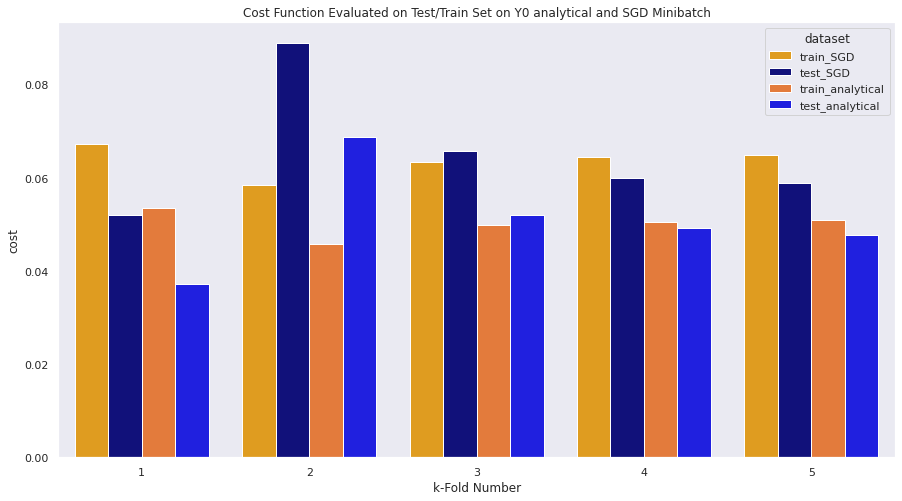

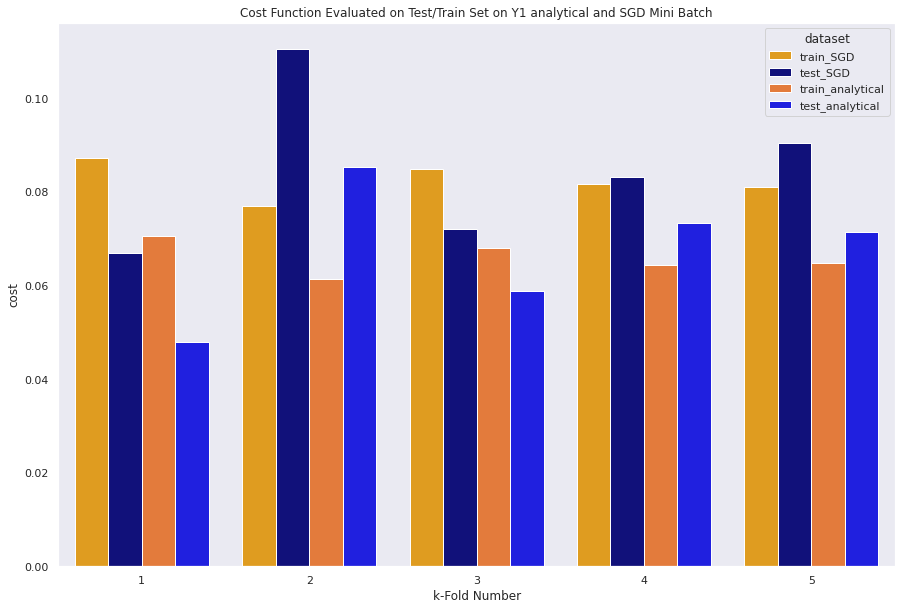

In [20]:
#Analytical Linear Regression
linreg = LinearRegression()

#Mini batch SGD Linear Regression
optimizer = BatchGradientDescent(batch_size=64, learning_rate=.1, epsilon=1e-4, max_iters=1e3)
linreg_SGD = LinearRegression(optimizer = optimizer)

crossval = KFoldValidation(linreg)
crossval_SGD = KFoldValidation(linreg_SGD)

x_columns = list(filter(lambda x: x.startswith('X'), df.columns))
y_columns = list(filter(lambda x: x.startswith('Y'), df.columns))

X = df.loc[:,x_columns].values
Y = df.loc[:,y_columns].values

#Run the cross validation on both labels Y0 and Y1 (Analytical Linear Regression)
results_analytical_Y0, predictions_analytical_Y0, weights_analytical_Y0 = crossval.run(X, Y[:,0])
results_analytical_Y1, predictions_analytical_Y1, weights_analytical_Y1 = deepcopy(crossval).run(X, Y[:,1])

#Run the cross validation on both labels Y0 and Y1 (Mini batch SGD Linear Regression)
results_SGD_Y0, predictions_SGD_Y0, weights_SGD_Y0 = crossval_SGD.run(X, Y[:,0])
results_SGD_Y1, predictions_SGD_Y1, weights_SGD_Y1 = deepcopy(crossval_SGD).run(X, Y[:,1])

#Specify which dataset the results are from to separate them in comparison
results_analytical_Y0['dataset'] += "_analytical"
results_analytical_Y1['dataset'] += "_analytical"

results_SGD_Y0['dataset'] += "_SGD"
results_SGD_Y1['dataset'] += "_SGD"

#Combine the results from different result
results_Y0 = [results_SGD_Y0,results_analytical_Y0]
results_Y0 = pd.concat(results_Y0)

results_Y1 = [results_SGD_Y1,results_analytical_Y1]
results_Y1 = pd.concat(results_Y1)

palette = {'train_analytical': "#ff7420", 'train_SGD': "#ffa500", 'test_analytical': "#0000ff",
           'test_SGD': "#00008b"}

# plot the cost function over each fold (for Y0 analytical and SGD Minibatch)
sns.set_style("darkgrid",{'axes.grid' : False})
plt.figure(figsize=(15,8))
sns.barplot(data=results_Y0, x='fold', y='cost', hue='dataset', palette=palette)
plt.xlabel('k-Fold Number')
plt.title('Cost Function Evaluated on Test/Train Set on Y0 analytical and SGD Minibatch')
plt.show()

# plot the cost function over each fold (for Y1 analytical and SGD Minibatch)
sns.set_style("darkgrid",{'axes.grid' : False})
plt.figure(figsize=(15,10))
sns.barplot(data=results_Y1, x='fold', y='cost', hue='dataset',ci = None, palette=palette)
plt.xlabel('k-Fold Number')
plt.title('Cost Function Evaluated on Test/Train Set on Y1 analytical and SGD Mini Batch')
plt.show()




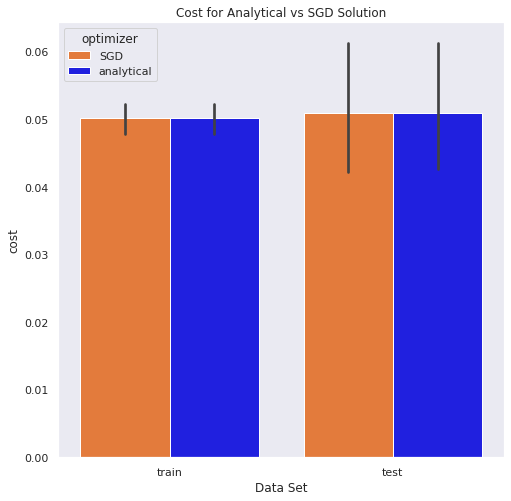

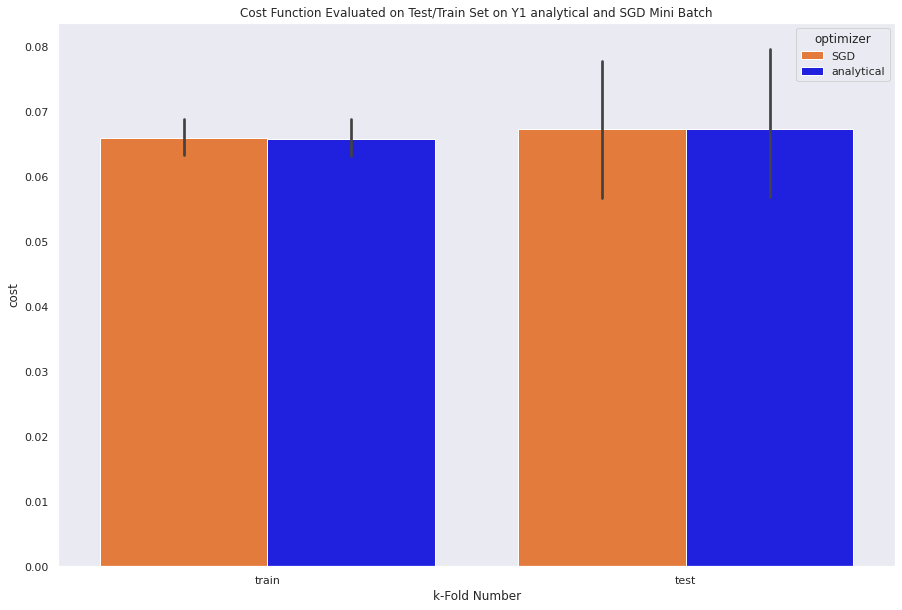

Computation time of the analytical solution: 0.10174762400001214


Computation time of the SGD solution: 53.20321805399999


In [21]:
from copy import deepcopy
import seaborn as sns
from time import process_time

#Analytical Linear Regression
linreg = LinearRegression()

#Mini batch SGD Linear Regression
optimizer = BatchGradientDescent(batch_size=64, learning_rate=.01, epsilon=1e-100, max_iters=1e5)
linreg_SGD = LinearRegression(optimizer = optimizer)

crossval = KFoldValidation(linreg)
crossval_SGD = KFoldValidation(linreg_SGD)

x_columns = list(filter(lambda x: x.startswith('X'), df.columns))
y_columns = list(filter(lambda x: x.startswith('Y'), df.columns))

X = df.loc[:,x_columns].values
Y = df.loc[:,y_columns].values

#Run the cross validation on both labels Y0 and Y1 (Analytical Linear Regression)

analytical_start = process_time() 
results_analytical_Y0, predictions_analytical_Y0, weights_analytical_Y0 = crossval.run(X, Y[:,0])
results_analytical_Y1, predictions_analytical_Y1, weights_analytical_Y1 = deepcopy(crossval).run(X, Y[:,1])
analytical_end = process_time() 

analytical_time = analytical_end - analytical_start 

#Run the cross validation on both labels Y0 and Y1 (Mini batch SGD Linear Regression)

SGD_start = process_time() 
results_SGD_Y0, predictions_SGD_Y0, weights_SGD_Y0 = crossval_SGD.run(X, Y[:,0])
results_SGD_Y1, predictions_SGD_Y1, weights_SGD_Y1 = deepcopy(crossval_SGD).run(X, Y[:,1])
SGD_end = process_time() 

SGD_time = SGD_end - SGD_start

#Specify which dataset the results are from to separate them in comparison
results_analytical_Y0['optimizer'] = "analytical"
results_analytical_Y1['optimizer'] = "analytical"

results_SGD_Y0['optimizer'] = "SGD"
results_SGD_Y1['optimizer'] = "SGD"

#Combine the results from different result
results_Y0 = [results_SGD_Y0,results_analytical_Y0]
results_Y0 = pd.concat(results_Y0)

results_Y1 = [results_SGD_Y1,results_analytical_Y1]
results_Y1 = pd.concat(results_Y1)

palette = {'SGD': "#ff7420", 'analytical': "#0000ff", 'test_analytical': "#0000ff",
           'test_SGD': "#00008b"}

# plot the cost function over each fold (for Y0 analytical and SGD Minibatch)
sns.set_style("darkgrid",{'axes.grid' : False})
plt.figure(figsize=(8,8))
sns.barplot(data=results_Y0, x='dataset', y='cost', hue='optimizer', palette=palette)
plt.xlabel('Data Set')
plt.title('Cost for Analytical vs SGD Solution')
plt.show()

# plot the cost function over each fold (for Y1 analytical and SGD Minibatch)
sns.set_style("darkgrid",{'axes.grid' : False})
plt.figure(figsize=(15,10))
sns.barplot(data=results_Y1, x='dataset', y='cost', hue='optimizer', palette=palette)
plt.xlabel('k-Fold Number')
plt.title('Cost Function Evaluated on Test/Train Set on Y1 analytical and SGD Mini Batch')
plt.show()

print("Computation time of the analytical solution:", analytical_time)
print('\n')
print("Computation time of the SGD solution:", SGD_time)




#Experiment Round 5
### Nonlinear basis functions

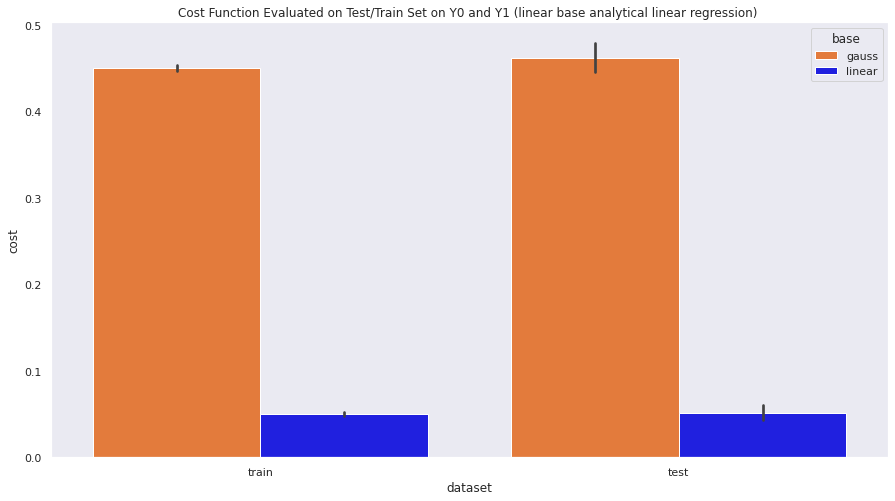

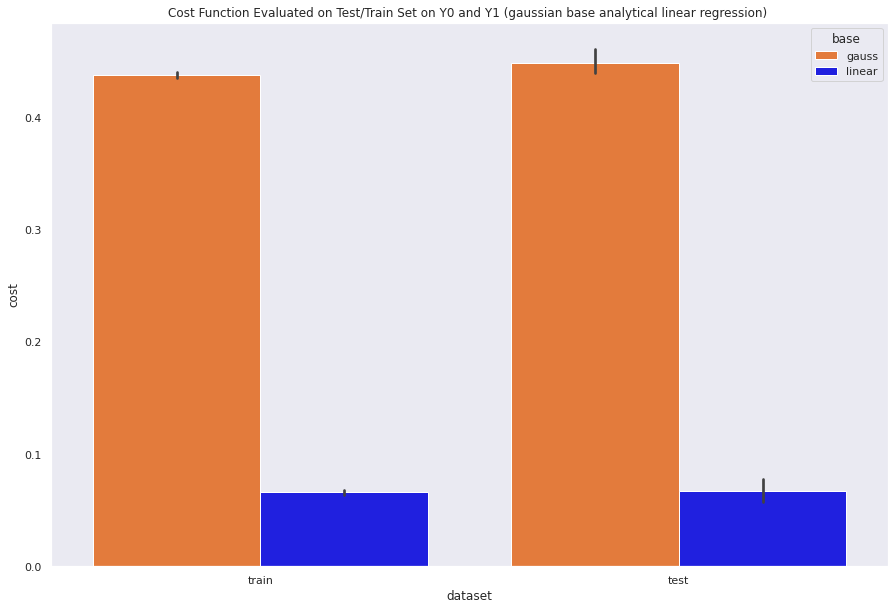

In [22]:
from copy import deepcopy

#Mini batch SGD Linear Regression
linreg_SGD = LinearRegression()
crossval = KFoldValidation(linreg)

x_columns = list(filter(lambda x: x.startswith('X'), df.columns))
y_columns = list(filter(lambda x: x.startswith('Y'), df.columns))

#Gaussian Base definition (data is already standartized)
Gaussian = lambda z: np.exp(-(z**2))
df_gaussian = df[x_columns].apply(Gaussian)

X = df.loc[:,x_columns].values
X_Gauss = df_gaussian.loc[:,x_columns].values
Y = df.loc[:,y_columns].values


#Run the cross validation on both labels Y0 and Y1 using Gaussian Bases
results_gauss_Y0, predictions_gauss_Y0, weights_gauss_Y0 = crossval.run(X_Gauss, Y[:,0])
results_gauss_Y1, predictions_gauss_Y1, weights_gauss_Y1 = deepcopy(crossval).run(X_Gauss, Y[:,1])

#Analytical Linear Regression Results
results_Y0, predictions_Y0, weights_Y0 = deepcopy(crossval).run(X, Y[:,0])
results_Y1, predictions_Y1, weights_Y1 = deepcopy(crossval).run(X, Y[:,1])

#Specify which dataset the results are from to separate them in comparison
results_gauss_Y0['base'] = "gauss"
results_gauss_Y1['base'] = "gauss"

results_analytical_Y0['base'] = "linear"
results_analytical_Y1['base'] = "linear"

#Combine the results from different result
results_Y0 = [results_gauss_Y0,results_analytical_Y0]
results_Y0 = pd.concat(results_Y0)

results_Y1 = [results_gauss_Y1,results_analytical_Y1]
results_Y1 = pd.concat(results_Y1)

palette = {'gauss': "#ff7420", 'linear': "#0000ff"}

# plot the cost function over each fold (for Y0 analytical and SGD Minibatch)
sns.set_style("darkgrid",{'axes.grid' : False})
plt.figure(figsize=(15,8))
sns.barplot(data=results_Y0, x='dataset', y='cost', hue='base', palette=palette)
plt.title('Cost Function Evaluated on Test/Train Set on Y0 and Y1 (linear base analytical linear regression) ')
plt.show()

# plot the cost function over each fold (for Y1 analytical and SGD Minibatch)
sns.set_style("darkgrid",{'axes.grid' : False})
plt.figure(figsize=(15,10))
sns.barplot(data=results_Y1, x='dataset', y='cost', hue='base', palette=palette)
plt.title('Cost Function Evaluated on Test/Train Set on Y0 and Y1 (gaussian base analytical linear regression) ')
plt.show()

